In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3, EfficientNetB0, ResNet50, VGG16



In [ ]:
target_size = (224, 224)
SEED = 42
BATCH_SIZE = 32
BUFFER_SIZE = 1024
AUTOTUNE = tf.data.experimental.AUTOTUNE

##ImageProcessor:

In [ ]:
class ImageProcessor:

    @staticmethod
    def augment_images(images):
        datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )

        augmented_images = []
        for img in images:
            img = img.reshape((1,) + img.shape)
            for batch in datagen.flow(img, batch_size=1):
                augmented_images.append(batch[0])
                break

        return np.array(augmented_images)

##DataLoader

In [ ]:
class DataLoader:

    @staticmethod
    def read_and_resize_images(folder_path, label, target_shape=(224, 224)):
        images = []
        labels = []

        for filename in os.listdir(folder_path):
            if filename.endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(folder_path, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, target_shape)
                    if img.shape[:2] == target_shape:
                        images.append(img)
                        labels.append(label)

        num_images = len(images)
        print(f"Loaded {num_images} images for class {label} from folder {folder_path}")
        return images, labels

    @staticmethod
    def load_dataset(root_folder):
        all_images = []
        all_labels = []
        class_folders = sorted(os.listdir(root_folder))

        for label, class_folder in enumerate(class_folders):
            class_path = os.path.join(root_folder, class_folder)
            if os.path.isdir(class_path):
                images, labels = DataLoader.read_and_resize_images(class_path, label)
                all_images.extend(images)
                all_labels.extend(labels)

        return class_folders, np.array(all_images), np.array(all_labels)

    @staticmethod
    def plot_images(images, labels, class_folders):
        num_classes = len(class_folders)
        fig, axes = plt.subplots(1, num_classes, figsize=(15, 3))

        for i in range(num_classes):
            class_images = images[labels == i]
            axes[i].imshow(class_images[0][:, :, ::-1])
            axes[i].set_title(f" {class_folders[i]}")
            axes[i].axis('off')

        plt.show()

    @staticmethod
    def split_dataset(images, labels, batch_size, seed=42, validation_size=0.2):
        # Split dataset into training and validation sets
        train_images, val_images, train_labels, val_labels = train_test_split(
            images, labels, test_size=validation_size, random_state=seed)

        # Create tf.data.Dataset for training and validation
        train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
        val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

        # Shuffle and batch the training dataset, and prefetch it for better performance
        train_dataset = train_dataset.shuffle(buffer_size=len(train_images), seed=seed).batch(batch_size).prefetch(AUTOTUNE)

        # Batch the validation dataset, and prefetch it
        val_dataset = val_dataset.batch(batch_size).prefetch(AUTOTUNE)

        return train_dataset, val_dataset

In [ ]:
class ModelTrainer:

    @staticmethod
    def build_model(base_model, num_classes):
        # Freeze the base model layers
        for layer in base_model.layers:
            layer.trainable = False

        # Create a custom model on top of the pre-trained base
        model = models.Sequential()
        model.add(base_model)
        model.add(layers.Flatten())
        model.add(layers.Dense(256, activation='relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(num_classes, activation='softmax'))

        return model

    @staticmethod
    def compile_model(model):
        # Compile the model
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model

    @staticmethod
    def train_model(model, train_dataset, val_dataset, epochs=5):
        # Train the model using tf.data.Dataset
        history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)
        return model, history

    @staticmethod
    def plot_history(history):
        # Plotting losses and accuracy
        plt.figure(figsize=(12, 4))

        # Plot training & validation accuracy values
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(['Train', 'Test'], loc='upper left')

        # Plot training & validation loss values
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(['Train', 'Test'], loc='upper left')

        plt.tight_layout()
        plt.show()

    @staticmethod
    def save_model(model, file_path='saved_model.h5'):
        # Save the model
        model.save(file_path)

    @staticmethod
    def load_model(file_path='saved_model.h5'):
        # Load the saved model
        loaded_model = tf.keras.models.load_model(file_path)
        return loaded_model

    @staticmethod
    def evaluate_model(loaded_model, val_dataset):
        # Evaluate the loaded model
        eval_result = loaded_model.evaluate(val_dataset)
        print("Loaded Model - Loss: {}, Accuracy: {}".format(eval_result[0], eval_result[1]))

    @staticmethod
    def predict_with_model(loaded_model, sample_image_path, target_size):
        # Make predictions using the loaded model
        img = tf.keras.preprocessing.image.load_img(sample_image_path, target_size=target_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)
        img_array /= 255.0

        predictions = loaded_model.predict(img_array)
        predicted_class = tf.argmax(predictions[0]).numpy()

        print("Predicted Class:", predicted_class)


Loaded 0 images for class 0 from folder /content/drive/MyDrive/ Archaeological Sites in Jordan (1)/test
Loaded 0 images for class 1 from folder /content/drive/MyDrive/ Archaeological Sites in Jordan (1)/train


IndexError: index 0 is out of bounds for axis 0 with size 0

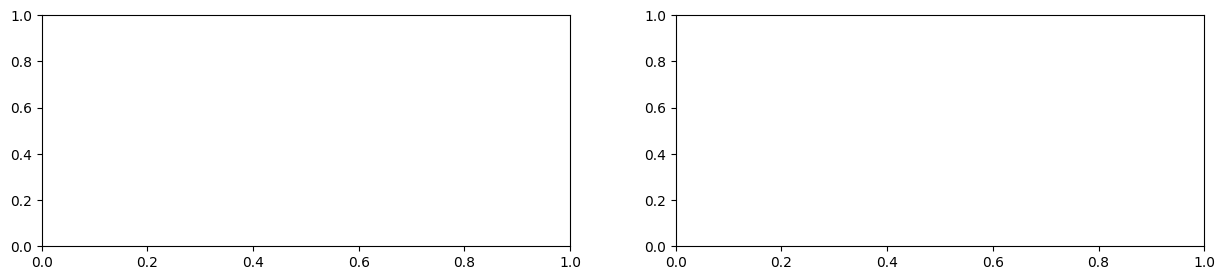

In [ ]:
class Application:

    @staticmethod
    def run(root_folder='/content/drive/MyDrive/ Archaeological Sites in Jordan (1)', target_size=(224, 224),
            batch_size=32, epochs=5):
        # Step 1: Load and preprocess data
        data_loader = DataLoader()
        class_folders, images, labels = data_loader.load_dataset(root_folder)
        data_loader.plot_images(images, labels, class_folders)

        # Step 2: Augment images
        augmented_images = ImageProcessor.augment_images(images)
        images = np.concatenate((images, augmented_images), axis=0)
        labels = np.concatenate((labels, labels), axis=0)

        # Step 3: Split dataset into training, validation
        train_dataset, val_dataset = DataLoader.split_dataset(images, labels, BATCH_SIZE, seed=SEED)

        # Step 4: Model training using InceptionV3
        inception_base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        custom_model = ModelTrainer.build_model(inception_base_model, len(class_folders))
        compiled_model = ModelTrainer.compile_model(custom_model)
        trained_model, history = ModelTrainer.train_model(compiled_model, train_dataset, val_dataset, epochs=epochs)
        ModelTrainer.plot_history(history)
        ModelTrainer.save_model(trained_model, 'inception_model.h5')

        # Step 5: Model training using EfficientNet
        efficientnet_base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        custom_model = ModelTrainer.build_model(efficientnet_base_model, len(class_folders))
        compiled_model = ModelTrainer.compile_model(custom_model)
        trained_model, history = ModelTrainer.train_model(compiled_model, train_dataset, val_dataset, epochs=epochs)
        ModelTrainer.plot_history(history)
        ModelTrainer.save_model(trained_model, 'efficientnet_model.h5')

        # Step 6: Model training using ResNet50
        resnet_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        custom_model = ModelTrainer.build_model(resnet_base_model, len(class_folders))
        compiled_model = ModelTrainer.compile_model(custom_model)
        trained_model, history = ModelTrainer.train_model(compiled_model, train_dataset, val_dataset, epochs=epochs)
        ModelTrainer.plot_history(history)
        ModelTrainer.save_model(trained_model, 'resnet_model.h5')

        # Step 7: Model training using VGG16
        vgg_base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        custom_model = ModelTrainer.build_model(vgg_base_model, len(class_folders))
        compiled_model = ModelTrainer.compile_model(custom_model)
        trained_model, history = ModelTrainer.train_model(compiled_model, train_dataset, val_dataset, epochs=epochs)
        ModelTrainer.plot_history(history)
        ModelTrainer.save_model(trained_model, 'vgg_model.h5')

if __name__ == "__main__":
    Application.run()